In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl

In [16]:
exps  = ['exp1','exp2','exp3','exp4']
funcs = ['sphere','rastrigin','rosenbrock']
freq = 1

In [17]:
def plot_one(exp, func, freq, ax, lbl_dict=None):
    measure = 'fitness'
    nn_path = Path(f'../../data/cluster_results/{exp}/{func}')
    nn_path = list(nn_path.glob(f'freq{freq}*nn_p3*nn_s3*'))[0]
    nonn_path = Path(f'../../data/cluster_results/{exp}/{func}')
    nonn_path = list(nonn_path.glob(f'freq{freq}*nn_p3*nn_s*'))[0]#was s2 i removed 2
    files = [o for o in nn_path.glob(f'*{measure}*') if ('NNdrop' not in o.name) and ('nn_s3' in o.parent.name)] +\
            [o for o in nn_path.glob(f'*{measure}*') if ('Cw' in o.parent.name)] +\
            [o for o in nn_path.glob(f'*{measure}*') if ('RI' in o.parent.name)] +\
            [o for o in nonn_path.glob(f'*{measure}*') if ('noNN' in o.name) and ('nn_s3' in o.parent.name)] +\
            [Path(f'../../data/results/{exp}/{func}/best_known.csv')]
    print(files)
    def read_values(x): return np.asarray(pd.read_csv(x)).mean(0)
    mean_values = [read_values(f) for f in files[:-1]]
    mean_values.append(np.asarray(pd.read_csv(files[-1]).fitness))

    for f,v in zip(files,mean_values):
        lbl = f.stem if lbl_dict is None else lbl_dict[f.stem]
        ax.plot(v, label=lbl, linewidth=2, alpha=0.65)

    return ax

[PosixPath('../../data/cluster_results/exp1/sphere/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp1/sphere/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp1/sphere/best_known.csv')]
[PosixPath('../../data/cluster_results/exp1/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp1/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp1/rastrigin/best_known.csv')]
[PosixPath('../../data/cluster_results/exp1/rosenbrock/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp1/rosenbrock/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp1/rosenbrock/best_known.csv')]
[Pos

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

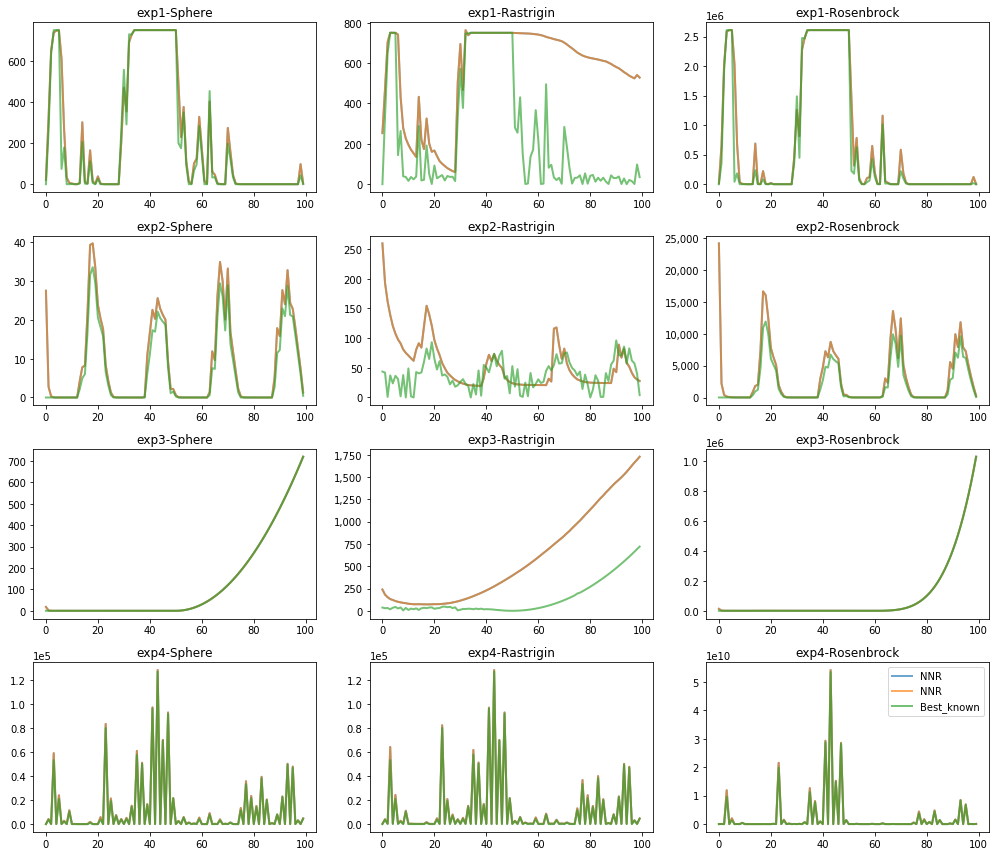

In [18]:
# Plot
fig,axs = plt.subplots(4, 3, figsize=(14,12))
lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
            'NNnorm_Random_fitness':'NNR',
            'noNNReval_fitness'    :'noNN',
            'best_known'           :'Best_known'}

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='upper right')#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq
fig.savefig(f'../../data/cluster_results/fitness{freq_lbl}.eps', dpi=400, format='eps')

[PosixPath('../../data/cluster_results/exp1/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp1/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp1/rastrigin/best_known.csv')]
[PosixPath('../../data/cluster_results/exp2/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp2/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp2/rastrigin/best_known.csv')]
[PosixPath('../../data/cluster_results/exp3/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp3/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp3/rastrigin/best_known.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

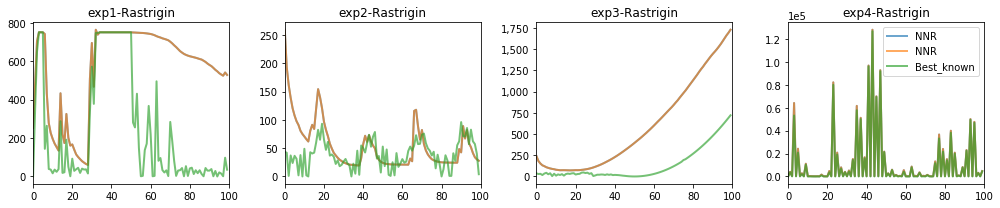

In [19]:
# Plot
fig,axs = plt.subplots(1, 4, figsize=(14,3))
lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
            'NNnorm_Random_fitness':'NNR',
            'noNNReval_fitness'    :'noNN',
            'best_known'           :'Best_known'}

for ax,exp in zip(axs,exps):
    func = 'rastrigin'
    plot_one(exp, func, freq, ax, lbl_dict)
    ax.set_title(f'{exp}-{func.title()}')
    ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
    ax.set_xlim(0,100)
    if ax.get_ylim()[1] < 1e5:
        ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='upper right')#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq
fig.savefig(f'../../data/cluster_results/fitness_ras_.eps', dpi=400, format='eps')